### 0. Importación de librerías y carga de datos

In [359]:
# Librerías para manejo de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Composicion de pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split

# Regresion lineal
from sklearn.linear_model import LinearRegression

# Importar/ Exportar modelos
from joblib import dump, load

# Metricas
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# q-q plots
import scipy.stats as stats

# Para sacar un reporte estadístico que podemos usar para determinar las importancia de las variables explicativas.
import statsmodels.api as sm 

In [360]:
# Se cargan los datos
# Ubicación de los datos, deben estar en la misma carpeta que este notebook

#pais, liga = "belgica", "jupiler-pro-league"
#pais, liga = "espana", "laliga-ea-sports"
#pais, liga = "francia", "ligue-1"
#pais, liga = "inglaterra", "premier-league"
#pais, liga = "italia", "serie-a"
#pais, liga = "paises-bajos", "eredivisie"
#pais, liga = "portugal", "liga-portugal"
pais, liga = "turquia", "super-lig"
#pais, liga = "colombia", "primera-a"
#pais, liga = "brasil", "brasileirao-serie-a"


version = 0

db_location = f"data/{pais}_{liga}/version{version}/resultados_anteriores.csv"

# Se leen los datos, estan separados con ','
data = pd.read_csv(db_location, sep=',', encoding = 'utf-8', na_values = '-')

### 1. Entendimiento de los datos

In [361]:
# Se revisa la forma general de los datos cargados
data.shape

(313, 42)

In [362]:
# Se muestra una pequeña muestra de los datos
data.head()

,Date,HomeTeam,AwayTeam,HG,AG,HP,AP,HTS,ATS,HSI,...,ATP,HPC,APC,HT,AT,HA,AA,HDA,ADA,Resultado
0,07.06.2023 12:00,Ankaragucu,Adana Demirspor,1,2,53%,47%,16,11,7,...,NaN,NaN,NaN,NaN,NaN,121,107,79,56,-1
1,07.06.2023 12:00,Beşiktaş,Konyaspor,3,3,54%,46%,17,6,8,...,NaN,NaN,NaN,NaN,NaN,182,148,126,74,0
2,07.06.2023 12:00,Giresunspor,Antalyaspor,2,0,38%,62%,5,18,3,...,NaN,NaN,NaN,NaN,NaN,82,96,34,84,2
3,07.06.2023 12:00,Istanbulspor,Umraniyespor,4,0,63%,37%,24,3,12,...,NaN,NaN,NaN,NaN,NaN,128,86,94,31,4
4,06.06.2023 12:00,Başakşehir,Trabzonspor,3,1,63%,37%,16,17,6,...,NaN,NaN,NaN,NaN,NaN,93,86,52,51,2


In [363]:
# Se imprimen los diferentes tipos de las columnas. Todas son numéricas
data.dtypes

Date          object
HomeTeam      object
AwayTeam      object
HG             int64
AG             int64
HP            object
AP            object
HTS            int64
ATS            int64
HSI            int64
ASI            int64
HSO            int64
ASO            int64
HBS          float64
ABS          float64
HFK          float64
AFK          float64
HC             int64
AC             int64
HOFF           int64
AOFF           int64
HTI          float64
ATI          float64
HGS            int64
AGS            int64
HF             int64
AF             int64
HRC          float64
ARC          float64
HYC          float64
AYC          float64
HTP          float64
ATP          float64
HPC          float64
APC          float64
HT           float64
AT           float64
HA             int64
AA             int64
HDA            int64
ADA            int64
Resultado      int64
dtype: object

In [364]:
# Se hace una decripción de los datos
data.describe()

,HG,AG,HTS,ATS,HSI,ASI,HSO,ASO,HBS,ABS,...,ATP,HPC,APC,HT,AT,HA,AA,HDA,ADA,Resultado
count,313.00000,313.00000,313.00000,313.00000,313.00000,313.00000,313.00000,313.00000,299.00000,299.00000,...,264.00000,264.00000,264.00000,264.00000,264.00000,313.00000,313.00000,313.00000,313.00000,313.00000
mean,1.69329,1.35463,14.04792,11.60703,5.18850,4.10224,5.70927,4.68371,3.29766,2.95318,...,429.88258,358.11364,343.91288,16.37879,16.23485,100.62620,96.46006,68.66454,60.76677,0.33866
std,1.35939,1.23210,5.43265,4.90900,2.75488,2.40907,2.75526,2.54176,2.12883,2.12159,...,103.31228,101.93684,103.83570,5.43616,5.12262,23.45203,23.23223,21.26118,21.47897,1.88287
min,0.00000,0.00000,3.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,177.00000,131.00000,120.00000,6.00000,4.00000,39.00000,41.00000,25.00000,22.00000,-7.00000
25%,1.00000,0.00000,10.00000,8.00000,3.00000,2.00000,4.00000,3.00000,2.00000,1.00000,...,356.00000,285.00000,272.75000,13.00000,13.00000,85.00000,81.00000,55.00000,47.00000,-1.00000
50%,1.00000,1.00000,13.00000,11.00000,5.00000,4.00000,5.00000,4.00000,3.00000,3.00000,...,423.50000,347.50000,336.50000,16.00000,16.00000,99.00000,94.00000,66.00000,58.00000,0.00000
75%,2.00000,2.00000,17.00000,14.00000,7.00000,5.00000,7.00000,6.00000,5.00000,4.00000,...,494.25000,428.25000,409.25000,19.00000,20.00000,114.00000,108.00000,81.00000,72.00000,1.00000
max,6.00000,7.00000,31.00000,35.00000,17.00000,13.00000,15.00000,14.00000,10.00000,12.00000,...,749.00000,663.00000,659.00000,48.00000,39.00000,214.00000,216.00000,136.00000,171.00000,6.00000


### 2. Identificación de variables a utilizar

In [365]:
selected_cols = ['HTS', 'ATS', 'HSI', 'ASI', 'HSO', 'ASO', 'HBS', 'ABS', 'HGS', 'AGS', 'HRC', 'ARC']
#selected_cols2 = ['HP', 'AP', 'HFK', 'AFK', 'HC', 'AC', 'HOFF', 'AOFF', 'HTI', 'ATI', 'HF', 'AF', 'HRC', 'ARC',
#                    'HYC', 'AYC', 'HTP', 'ATP', 'HPC', 'APC', 'HT', 'AT', 'HA', 'AA', 'HDA', 'ADA']
#selected_cols = [ # "Date", "HomeTeam", "AwayTeam",
                  # 'HTS', 'ATS',
#                    'HSI', 'ASI', 'HSO', 'ASO', 'HBS', 'ABS', 'HGS', 'AGS',
#                    'HP', 'AP', 'HFK', 'AFK', 'HC', 'AC', 'HOFF', 'AOFF', 'HTI', 'ATI', 'HF', 'AF', 'HRC', 'ARC',
#                    'HYC', 'AYC', 'HTP', 'ATP', 'HPC', 'APC', # 'HT', 'AT',
#                    'HA', 'AA', 'HDA', 'ADA']


### 3. Limpieza y preparación de datos

In [366]:
# los pasos de limpieza y preparación se realizan sobre otro archivo
df_data = data.copy()[selected_cols]
df_data.insert(0, "Resultado", data["Resultado"])

In [367]:
# Se observa que no existen valores nulos en las variables
df_data.isnull().sum()

Resultado      0
HTS            0
ATS            0
HSI            0
ASI            0
HSO            0
ASO            0
HBS           14
ABS           14
HGS            0
AGS            0
HRC          240
ARC          240
dtype: int64

In [368]:
# Se ajusta el formato de la posesión
def convert_possession(value):
    if len(value) > 0:
        value2 = str(value)  # cast to string
        value3 = value2[:-1] # last four characters

        return float(value3)
    else:
        return value

#df_data['HP'] = df_data['HP'].apply(convert_possession)
#df_data['AP'] = df_data['AP'].apply(convert_possession)

In [369]:
# Se ajustan las tarjetas amarillas
def convert_yellow_cards(value):
    return int(value)

#df_data['HYC'] = df_data['HYC'].fillna(0)
#df_data['AYC'] = df_data['AYC'].fillna(0)
#df_data['HYC'] = df_data['HYC'].apply(convert_yellow_cards)
#df_data['AYC'] = df_data['AYC'].apply(convert_yellow_cards)

In [370]:
# Se ajustan las tarjetas rojas
df_data['HRC'] = df_data['HRC'].fillna(0)
df_data['ARC'] = df_data['ARC'].fillna(0)

In [371]:
# Se llenan los valores vacios de HBS y ABS
#df_data['HBS'] = df_data['HBS'].fillna(0)
#df_data['ABS'] = df_data['ABS'].fillna(0)

In [372]:
# Se llenan los valores vacios de HFK y AFK
#df_data['HFK'] = df_data['HFK'].fillna(0)
#df_data['AFK'] = df_data['AFK'].fillna(0)

In [373]:
# Se llenan los valores vacios de HTI y ATI
#df_data['HTI'] = df_data['HTI'].fillna(0)
#df_data['ATI'] = df_data['ATI'].fillna(0)

In [374]:
# Se llenan los valores vacios de HTP y ATP           
#df_data['HTP'] = df_data['HTP'].fillna(0)
#df_data['ATP'] = df_data['ATP'].fillna(0)

In [375]:
# Se llenan los valores vacios de HPC y APC
#df_data['HPC'] = df_data['HPC'].fillna(0)
#df_data['APC'] = df_data['APC'].fillna(0)

In [376]:
# Se llenan los valores vacios de HT y AT
#df_data['HT'] = df_data['HT'].fillna(0)
#df_data['AT'] = df_data['AT'].fillna(0)

In [377]:
df_data.isnull().sum()

Resultado     0
HTS           0
ATS           0
HSI           0
ASI           0
HSO           0
ASO           0
HBS          14
ABS          14
HGS           0
AGS           0
HRC           0
ARC           0
dtype: int64

In [378]:
df_data.shape

(313, 13)

In [379]:
df_data = df_data.dropna()
df_data.shape

(299, 13)

In [380]:
# Se llenan los valores nulos con el promedio de local o visitante de ese equipo (según el archivo)
def fill_based_on_another_column(row):
    if pd.isnull(row['HTP']):
        #print(row[["Date", "HomeTeam", "AwayTeam", "HG", "AG"]])
        #if row['another_column'] == 'A':
        #    return 'value_for_A'
        return row['HTP']
    return row['HTP']

# Fill null values in the 'column_name' column based on 'another_column'
#df_data['HTP'] = df_data.apply(fill_based_on_another_column, axis=1)

In [381]:
df_data.head()
output_file = 'output.xlsx'
df_data.to_excel(output_file, index=False)

<AxesSubplot:>

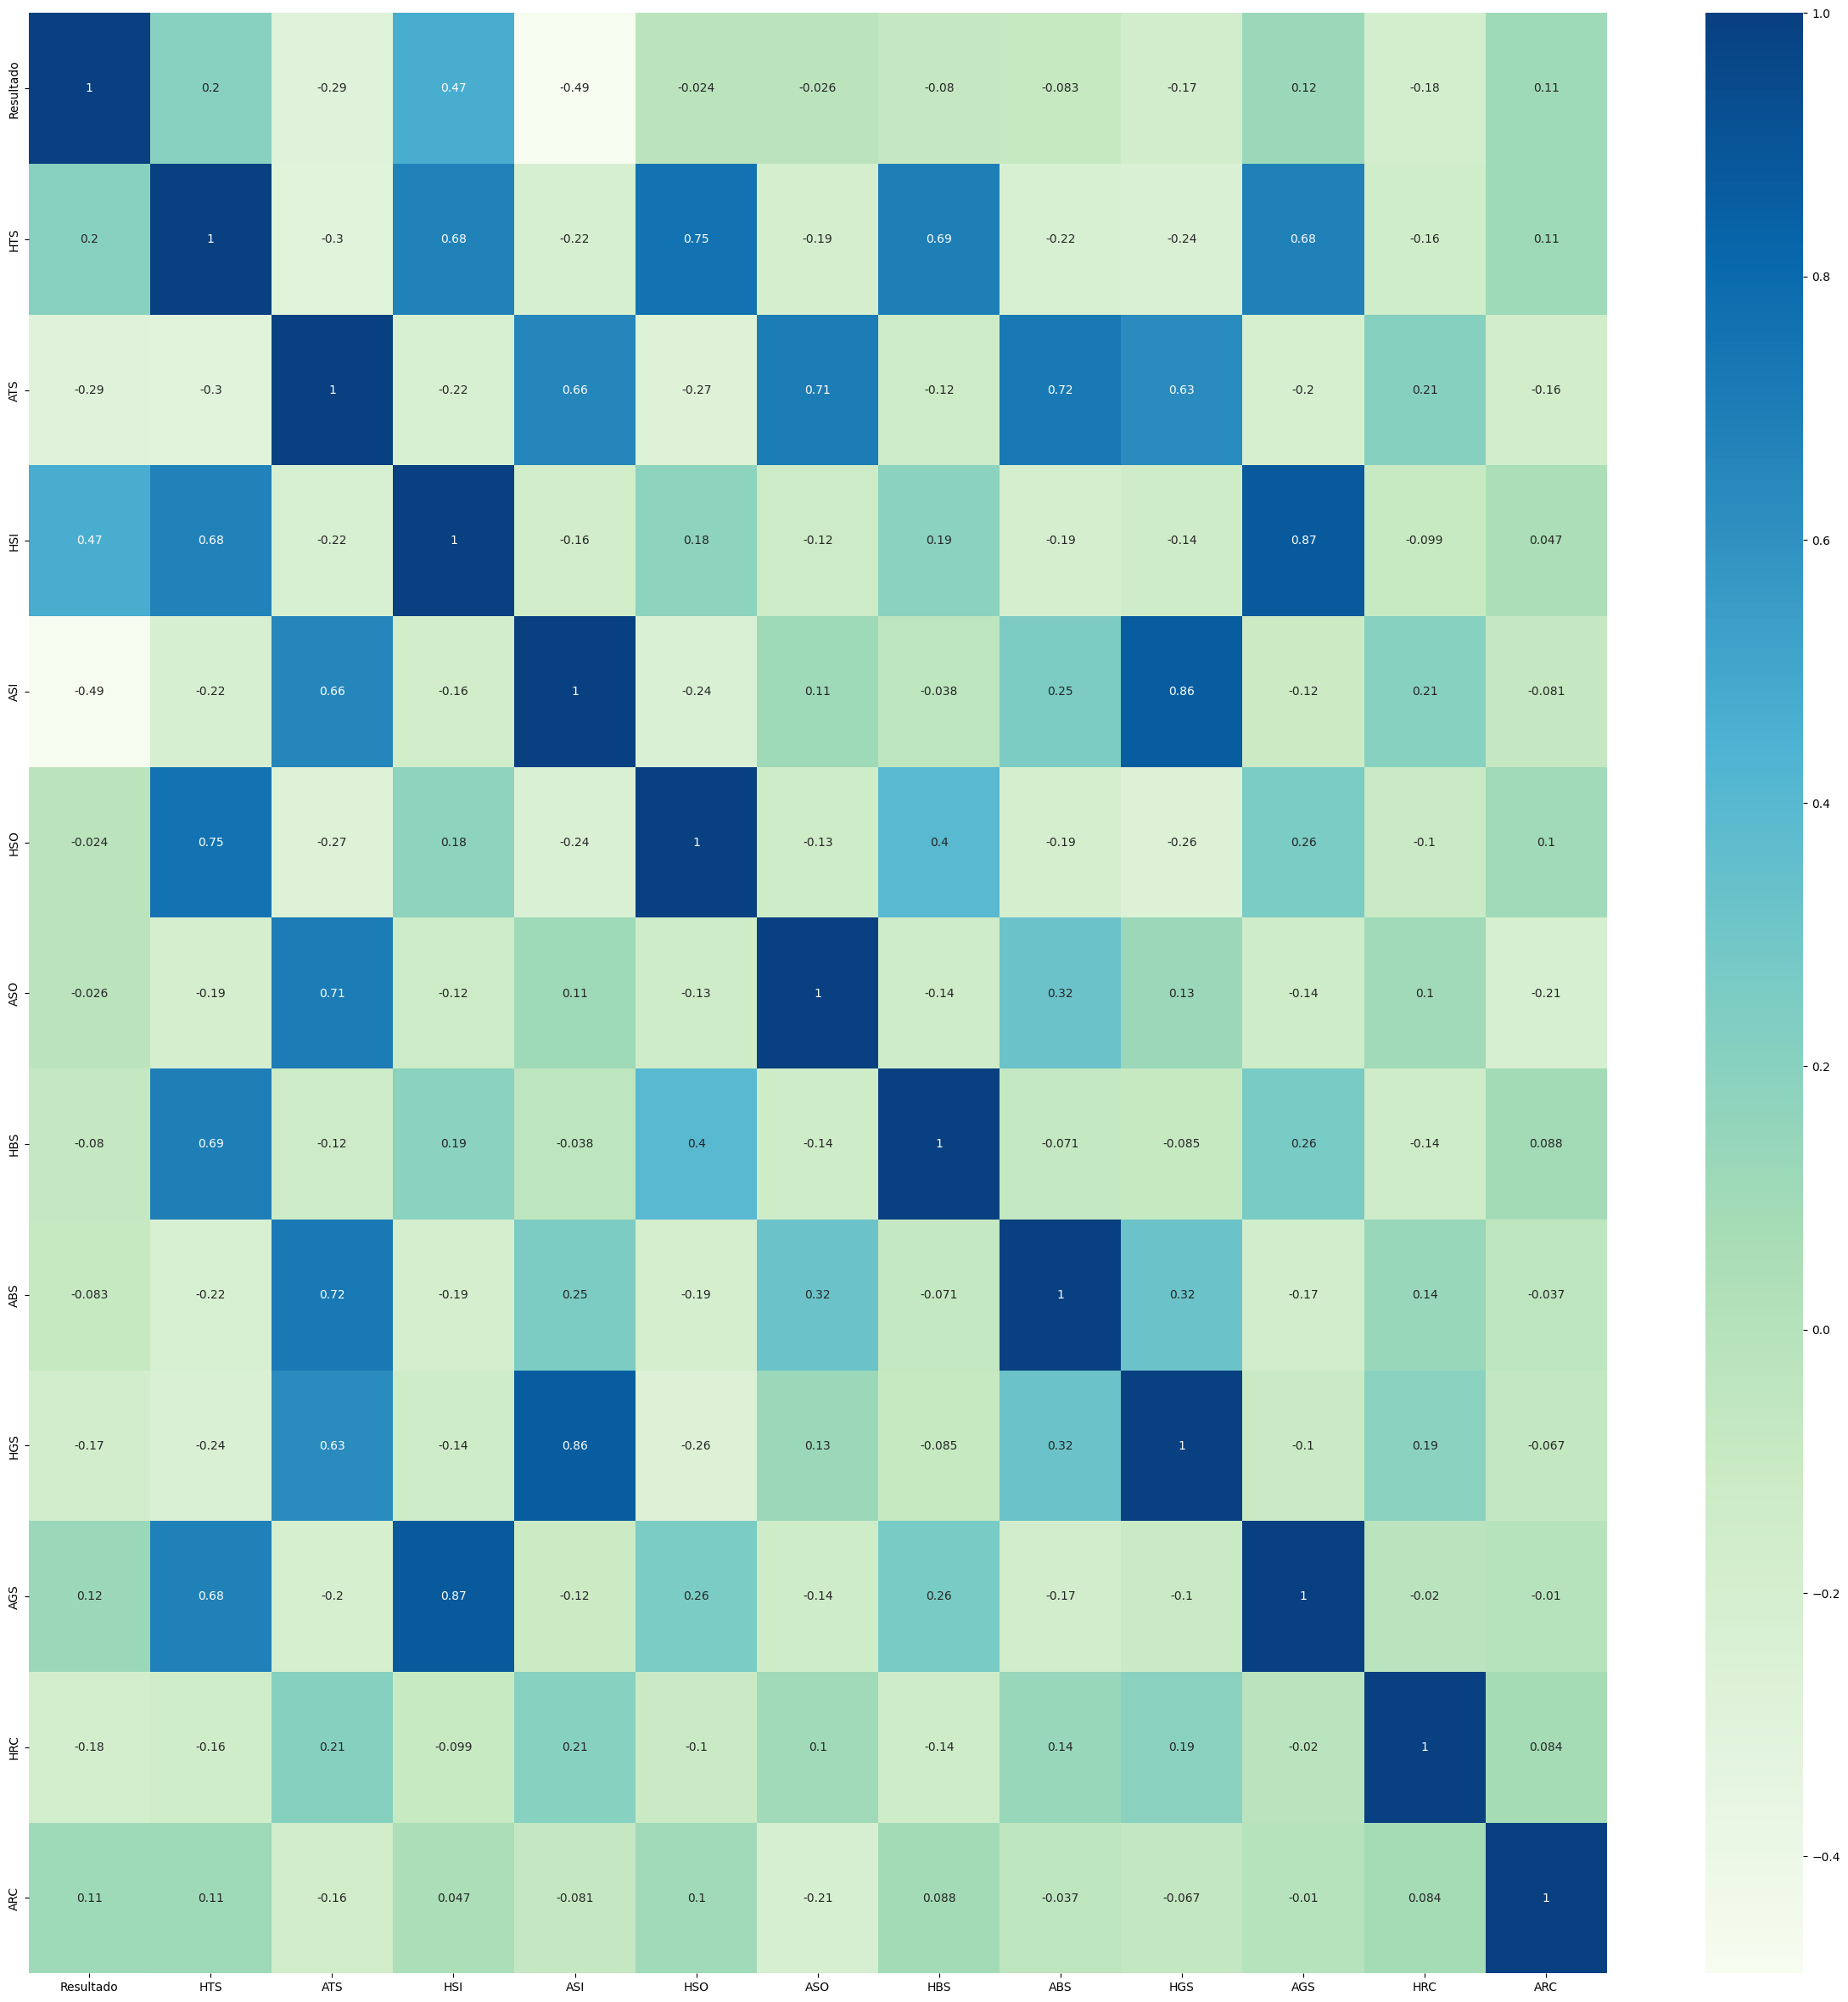

In [382]:
# Se revisa si la variable objetivo está correlacionada con otra variable
plt.figure(figsize =(30,30))
correlacion = df_data.corr()
sns.heatmap(correlacion, cmap = 'GnBu', annot = True)

In [383]:
# Se diagrama la relación entre cada variable explicativa y la variable objetivo
#sns.pairplot(df_data, height=3, y_vars = 'Resultado', x_vars = df_data.columns[0:4], kind='scatter')
#sns.pairplot(df_data, height=3, y_vars = 'Resultado', x_vars = df_data.columns[4:10], kind='scatter')
#sns.pairplot(df_data, height=3, y_vars = 'Resultado', x_vars = df_data.columns[8:12], kind='scatter')
#sns.pairplot(df_data, height=3, y_vars = 'Resultado', x_vars = df_data.columns[12:16], kind='scatter')
#sns.pairplot(df_data, height=3, y_vars = 'Resultado', x_vars = df_data.columns[16:20], kind='scatter')
#sns.pairplot(df_data, height=3, y_vars = 'Resultado', x_vars = df_data.columns[20:24], kind='scatter')
#sns.pairplot(df_data, height=3, y_vars = 'Resultado', x_vars = df_data.columns[24:28], kind='scatter')
#sns.pairplot(df_data, height=3, y_vars = 'Resultado', x_vars = df_data.columns[28:32], kind='scatter')

### 4. Modelamiento

In [384]:
#df_data.drop('Date', axis = 1, inplace=True)
#df_data.drop('HomeTeam', axis = 1, inplace=True)
#df_data.drop('AwayTeam', axis = 1, inplace=True)

#### Pipeline 1: solo con selección de variables

In [385]:
# Se usa un transformador para seleccionar unicamente las columnas que se quieren usar
pre = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols)])),]
# Se declara el modelo
model = [('model', LinearRegression())]
# Se declara el pipeline
pipeline1 = Pipeline(pre+model)

In [386]:
# Se extraen las variables explicativas y objetivo para entrenar
df_datap1 = df_data

X = df_datap1.drop('Resultado', axis = 1)
Y = df_datap1['Resultado']

# Se realiza la división entrenamiento - test. Se deja 20% de los datos para el test.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Se entrena el modelo
pipeline1 = pipeline1.fit(X_train,Y_train)

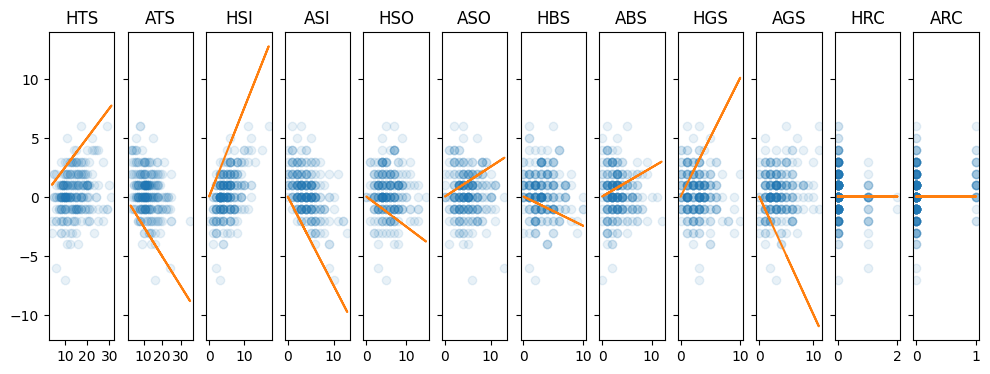

In [387]:
# Se visualiza la regresion lineal en cada dimension
f, axs = plt.subplots(1, len(selected_cols), sharey=True, figsize = (12,4))

for i in range(len(selected_cols)):
    pos_col = i
    col = selected_cols[pos_col]

    # Variable x
    x = X_train[col]
    # Pendiente
    m = pipeline1['model'].coef_[pos_col]
    # Interceto
    b = pipeline1['model'].intercept_

    axs[i].plot(x, Y_train, 'o', alpha = 0.1)
    axs[i].plot(x, x*m + b)
    axs[i].set_title(col)

In [388]:
# Vale la pena hacer estandarización de los datos para tener coeficientes más comparables en misma escala.
importancia = pipeline1['model'].coef_
pd.options.display.float_format = '{:.5f}'.format
importancia_atributo = pd.DataFrame(data={"Atributo": selected_cols,"Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo

,Atributo,Importancia
0,HGS,1.00517
1,HSI,0.74785
2,ASO,0.25275
3,HTS,0.24842
4,ABS,0.24583
5,ARC,0.00588
6,HRC,0.00051
7,HBS,-0.24650
8,ATS,-0.25281
9,HSO,-0.25293


In [389]:
# Se obtienen las predicciones del modelo sobre el conjunto de entrenamiento.
y_pred = pipeline1.predict(X_train)
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print("Estadísticas Pipeline #1 - Datos de entrenamiento")
print("RMSE: %.2f" % np.sqrt(mse(Y_train, y_pred)))
print('R²: %.2f' % r2_score(Y_train, y_pred))

Estadísticas Pipeline #1 - Datos de entrenamiento
RMSE: 0.13
R²: 1.00


In [390]:
# Se obtienen las predicciones del modelo sobre el conjunto de test.
y_pred = pipeline1.predict(X_test)
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print("Estadísticas Pipeline #1 - Datos de test")
print("RMSE: %.2f" % np.sqrt(mse(Y_test, y_pred)))
print('R²: %.2f' % r2_score(Y_test, y_pred))

Estadísticas Pipeline #1 - Datos de test
RMSE: 0.29
R²: 0.98


<AxesSubplot:>

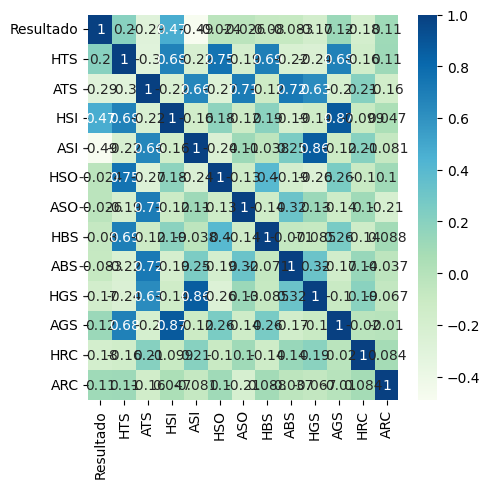

In [391]:
# Se revisa la colinealidad
df_temp = df_datap1[selected_cols]
plt.figure(figsize =(5,5))
correlacion = df_datap1.corr()
sns.heatmap(correlacion, cmap = 'GnBu', annot = True)

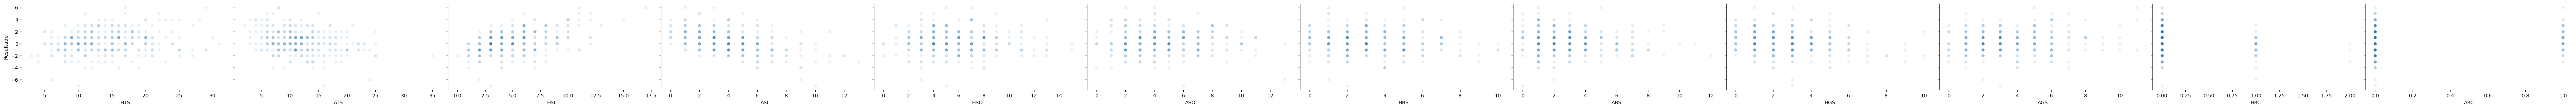

In [392]:
# Linealidad
#Se ven datos relativamente juntos, sin embargo, hay una pequeña cantidad de datos fuera de esta cohesión en las tres variables.
sns.pairplot(df_datap1, height=3, aspect = 2, y_vars = 'Resultado', x_vars = selected_cols, kind='scatter', plot_kws = {'alpha':0.1})

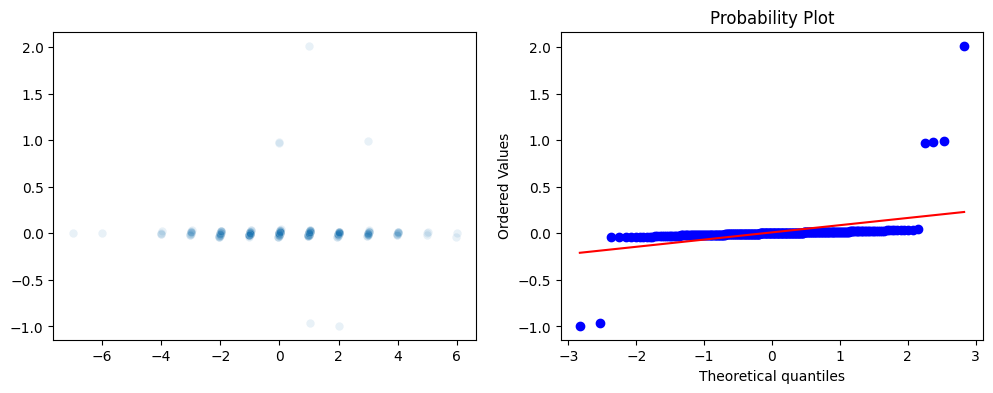

In [393]:
# Nos sirve para revisar si los errores vienen con una distribución teoríca. En este caso, de una distribución normal.
X = df_data.drop('Resultado', axis = 1)
y = df_data['Resultado']

# Calculamos los errores
errors = (pipeline1.predict(X) - y).values

fig, axes = plt.subplots(1, 2, figsize = (12,4))

# Dispersión
sns.scatterplot(x = pipeline1.predict(X), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

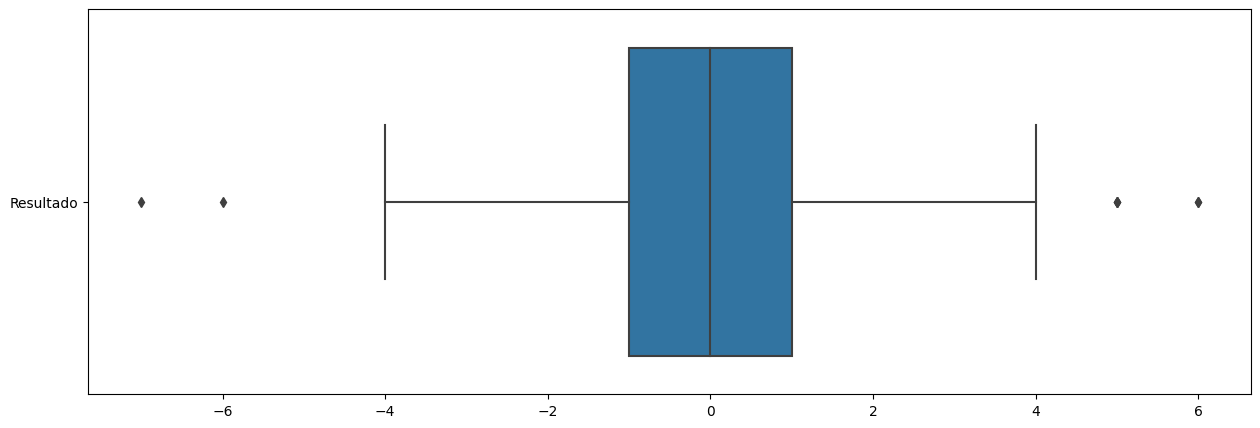

In [394]:
# Diagrama de caja
# Acá podemos ver los valores atípicos de Life expectancy.
# En este caso están los menores a 44.5.
fig=plt.figure(figsize=(15,5))
ax = sns.boxplot(data= df_datap1[['Resultado']], orient="h")

#### Pipeline 2: Modelo con eliminación de valores atípicos en la variable objetivo y estandarización

In [395]:
# Se eliminan los valores atípicos que indica el diagrama de caja.
df_datap2 = df_data
df_datap2 = df_datap2.drop(df_datap2[df_datap2['Resultado'] <= -2].index)
df_datap2 = df_datap2.drop(df_datap2[df_datap2['Resultado'] > 2].index)

In [396]:
# Se declara el modelo
model2 = [('model2', LinearRegression())]

#Pre
pre = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols)])),
       ('scaler', StandardScaler()),]

# Se declara el pipeline
pipeline2 = Pipeline(pre+model2)

# Se extraen las variables explicativas y objetivo para entrenar
X = df_datap2.drop('Resultado', axis = 1)
Y = df_datap2['Resultado']

# Se realiza la división entrenamiento - test. Se deja 20% de los datos para el test.
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=0)

# Se entrena el modelo
pipeline2 = pipeline2.fit(X_train,Y_train)

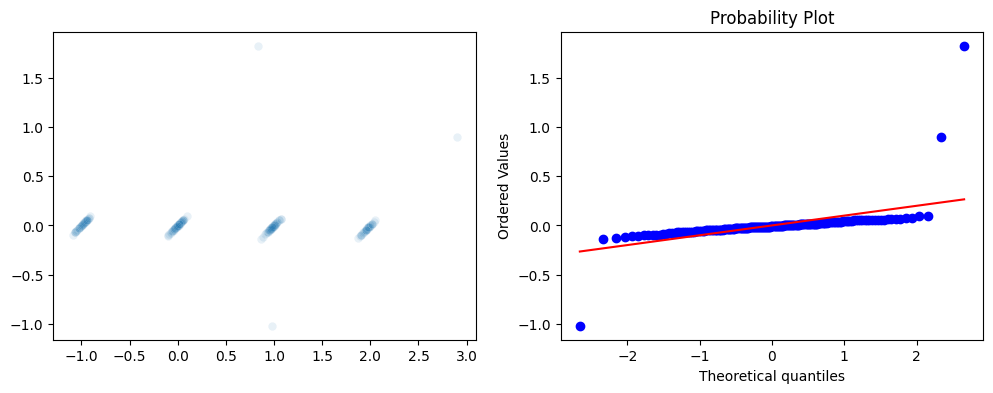

In [397]:
# Se calculan los errores
errors = (pipeline2.predict(X_train) - Y_train).values

fig, axes = plt.subplots(1, 2, figsize = (12,4))

# Dispersión
sns.scatterplot(x = pipeline2.predict(X_train), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

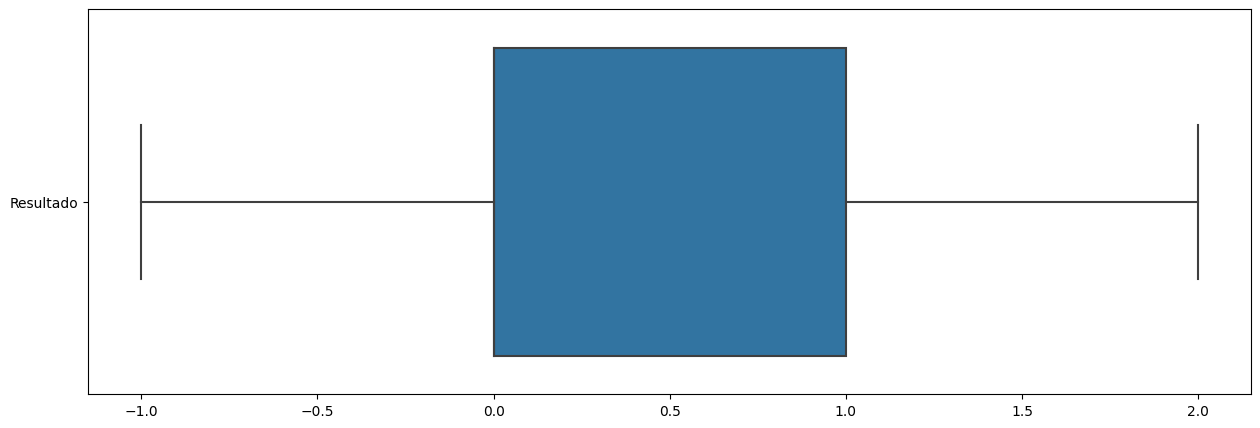

In [398]:
# Diagrama de caja
# Se ve que los datos ya están eliminados
fig=plt.figure(figsize=(15,5))
ax = sns.boxplot(data= df_datap2[['Resultado']], orient="h")

In [399]:
# Se obtienen las predicciones del modelo sobre el conjunto de entrenamiento.
y_pred = pipeline2.predict(X_train)
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print("Estadísticas Pipeline #2 - Datos de entrenamiento")
print("RMSE: %.2f" % np.sqrt(mse(Y_train, y_pred)))
print('R²: %.2f' % r2_score(Y_train, y_pred))

Estadísticas Pipeline #2 - Datos de entrenamiento
RMSE: 0.18
R²: 0.97


In [400]:
# Se obtienen las predicciones del modelo sobre el conjunto de test.
y_pred = pipeline2.predict(X_test)
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print("Estadísticas Pipeline #2 - Datos de test")
print("RMSE: %.2f" % np.sqrt(mse(Y_test, y_pred)))
print('R²: %.2f' % r2_score(Y_test, y_pred))

Estadísticas Pipeline #2 - Datos de test
RMSE: 0.22
R²: 0.92


### 5. Evaluación cuantitativa

In [401]:
# Se ajusta el modelo para ver el reporte de estadísticas
model = sm.OLS(Y, X).fit()
# Se muestran las estadísticas del modelo
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Resultado   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                              676.1
Date:                Fri, 11 Aug 2023   Prob (F-statistic):                   9.48e-154
Time:                        02:45:36   Log-Likelihood:                          56.865
No. Observations:                 220   AIC:                                     -93.73
Df Residuals:                     210   BIC:                                     -59.79
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HTS            0.2470      0.004     63.626      0.000       0.239       0.255
ATS           -0.2471      0.004    -57.932      0.000      -0.255      -0.239
HSI            0.7448      0.011     69.432      0.000       0.724       0.766
ASI           -0.7438      0.012    -61.204      0.000      -0.768      -0.720
HSO           -0.2558      0.006    -40.981      0.000      -0.268      -0.243
ASO            0.2509      0.006     41.010      0.000       0.239       0.263
HBS           -0.2421      0.007    -36.264      0.000      -0.255      -0.229
ABS            0.2459      0.007     33.857      0.000       0.232       0.260
HGS            0.9877      0.018     55.207      0.000       0.952       1.023
AGS           -0.9880      0.016    -61.867      0.000      -1.019      -0.957
HRC            0.0181      0.039      0.464      0.643      -0.059       0.095
ARC           -0.0422      0.039     -1.071      0.286      -0.120       0.036
==============================================================================
Omnibus:                      299.853   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32573.433
Skew:                          -5.880   Prob(JB):                         0.00
Kurtosis:                      61.439   Cond. No.                     3.62e+16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 8.27e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [402]:
# Se guarda el pipeline en el archivo
filename = 'model/modelo.joblib' # Ubicación del archivo a entregar
dump(pipeline2, filename)

['model/modelo.joblib']

In [403]:
# Proceso de prueba del cliente
df_recent = pd.read_csv(f"data/{pais}_{liga}/version{version}/proximos_partidos.csv", sep=',', encoding = 'utf-8', na_values = '-') # Lectura de los datos recientes
df_recent['HP'] = df_recent['HP'].apply(convert_possession)
df_recent['AP'] = df_recent['AP'].apply(convert_possession)

df_entrada = df_recent.copy()
df_entrada = df_entrada.drop(columns=['Resultado'])

columna_resultado = df_recent['Resultado']
df_recent = df_recent.drop(columns=['Resultado'])
df_recent = df_recent.dropna()
df_recent['Resultado'] = columna_resultado

df_recent.shape

(21, 42)

In [404]:
# Se lee el archivo y carga el modelo
pipeline = load(filename)

y_predicted = pipeline.predict(df_recent)

In [405]:
index_predecidos = 0
for i in range(len(df_entrada)):
    row = df_entrada.iloc[i]
    contains_nan = row.isna().any()

    if contains_nan:
        print("-")
    else:
        print ("{:.2f}".format(y_predicted[index_predecidos]).replace('.', ','))
        index_predecidos += 1

2,87
0,04
-0,42
-2,78
-
-
-
1,62
0,00
1,05
1,27
0,39
-
1,33
0,07
-0,55
-
0,08
-2,47
-
3,38
0,66
1,69
-2,58
0,03
-
-
-0,81
0,97
-


In [406]:
index_predecidos = 0
for i in range(len(df_entrada)):
    home_team = df_entrada.iloc[i]["HomeTeam"]
    away_team = df_entrada.iloc[i]["AwayTeam"]
    
    row = df_entrada.iloc[i]
    contains_nan = row.isna().any()

    if contains_nan:
        print(home_team + " vs " + away_team)
        print("El partido contiene un equipo recien ascendido.")
        print()
    else:
        print(home_team + " vs " + away_team)
        print(y_predicted[index_predecidos])
        ganador = home_team if y_predicted[index_predecidos] >= 0.5 else (away_team if y_predicted[index_predecidos] <= -0.5 else "ninguno")
        if ganador == "ninguno":
                print("No hay ganador claro. " + str(abs(y_predicted[index_predecidos]))[:4])
        else:
            print("Gana " + ganador + " por " + str(abs(y_predicted[index_predecidos]))[:4] + " goles")
        print()
        index_predecidos += 1

Trabzonspor vs Antalyaspor
2.8667324982424907
Gana Trabzonspor por 2.86 goles

Kasimpasa vs Ankaragucu
0.03753765730056102
No hay ganador claro. 0.03

Konyaspor vs Istanbulspor
-0.4228210021569654
No hay ganador claro. 0.42

Kayserispor vs Galatasaray
-2.7836410805538288
Gana Galatasaray por 2.78 goles

Pendikspor vs Hatayspor
El partido contiene un equipo recien ascendido.

Sivasspor vs Samsunspor
El partido contiene un equipo recien ascendido.

Adana Demirspor vs Rizespor
El partido contiene un equipo recien ascendido.

Fenerbahçe vs Gaziantep
1.6162717207672168
Gana Fenerbahçe por 1.61 goles

Alanyaspor vs Başakşehir
0.0012565621887261624
No hay ganador claro. 0.00

Karagumruk vs Beşiktaş
1.0478878744333264
Gana Karagumruk por 1.04 goles

Antalyaspor vs Konyaspor
1.265308571645848
Gana Antalyaspor por 1.26 goles

Istanbulspor vs Kayserispor
0.3920232735474325
No hay ganador claro. 0.39

Rizespor vs Alanyaspor
El partido contiene un equipo recien ascendido.

Galatasaray vs Trabzonspo